In [17]:
!pip install scikit-learn
!pip install pandas
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import re
!pip install emoji
import emoji
! pip install num2words
from num2words import num2words
!pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('wordnet')
!pip install matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tiast\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tiast\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


ModuleNotFoundError: No module named 'wordcloud'

In [4]:
def read_df_from_json(url):
    data_list = []

    with open(url, 'r') as file:
        for line in file:
            data = json.loads(line)
            label = ""
            if "overall" in data and "reviewText" in data and "summary" in data:
                if data["overall"] == 3.0:
                    label = "neutral"
                elif data["overall"] > 3.0:
                    label = "positive"
                elif data["overall"] < 3.0:
                    label = "negative"
                data_list.append({"label": label, "overall": data["overall"], "reviewText": data["reviewText"], "summary": data["summary"]})

        df = pd.DataFrame(data_list)
        df.drop_duplicates(subset=["reviewText"], inplace=True)
    
        return df
    return []


In [5]:
def concatenate_dfs(list_of_links):
    dfs = []

    for link in list_of_links:
        dfs.append(read_df_from_json(link))
    
    big_df = pd.concat(dfs, ignore_index=True)
    
    return big_df 


In [6]:
links = ['data/AMAZON_FASHION_5.json','data/All_Beauty_5.json','data/Luxury_Beauty_5.json','data/Clothing_Shoes_and_Jewelry_5.json']
df  = concatenate_dfs(links)

In [7]:
print("neutre:", df["label"].value_counts()["neutral"])
print("pozitive:", df["label"].value_counts()["positive"])
print("negative:", df["label"].value_counts()["negative"])

neutre: 876977
pozitive: 6520468
negative: 901322


In [6]:
# def create_test_train_samples(df):
# #     df = df.sort_values(by='label', ascending=True)
#     positive_labels = df[df['label'] == 'positive']
#     negative_labels = df[df['label'] == 'negative']
#     neutre_labels = df[df['label'] == 'neutral']


#     print(positive_labels.shape)
#     print(negative_labels.shape)
#     print(neutre_labels.shape)
#     print(df)
    

# create_test_train_samples(df)    

In [8]:
def split_and_write_csv(input_df, train_size_per_class=15000, test_size_per_class=2000):
    grouped = input_df.groupby('label')

    train_data = pd.DataFrame()
    train_labels = pd.DataFrame()
    test_data = pd.DataFrame()
    test_labels = pd.DataFrame()
    
    train_data_plot = pd.DataFrame()
    test_data_plot = pd.DataFrame()

    for group_name, group_df in grouped:
        shuffled_group_df = group_df.sample(frac=1, random_state=42)

        train_group, test_group = train_test_split(shuffled_group_df, train_size=train_size_per_class, test_size=test_size_per_class, random_state=42)
        
        train_data = pd.concat([train_data, train_group['reviewText']]) 
        train_labels = pd.concat([train_labels, train_group['label']])

        test_data = pd.concat([test_data, test_group['reviewText']])
        test_labels = pd.concat([test_labels, test_group['label']])
        
        train_data_plot = pd.concat([train_data_plot, train_group])  
        test_data_plot = pd.concat([test_data_plot, test_group])
        
    
    shuffled_train_data = train_data.sample(frac=1, random_state=42)
    shuffled_train_labels = train_labels.sample(frac=1, random_state=42)

    shuffled_train_data.rename(columns={0: "text"}, inplace=True)
    shuffled_train_labels.rename(columns={0: "label"}, inplace=True)
    
    test_data.rename(columns={0: "text"}, inplace=True)
    test_labels.rename(columns={0: "label"}, inplace=True)
    
    shuffled_train_data.to_csv('data/shuffled_train_data.csv', index=False)
    shuffled_train_labels.to_csv('data/shuffled_train_labels.csv', index=False)
    test_data.to_csv('data/test_data.csv', index=False)
    test_labels.to_csv('data/test_labels.csv', index=False)
    train_data_plot.to_csv('data/train_data_plot.csv', index=False)
    test_data_plot.to_csv('data/test_data_plot.csv', index=False)


In [9]:
split_and_write_csv(df)

train_data = pd.read_csv('data/shuffled_train_data.csv',index_col=None)
train_labels = pd.read_csv('data/shuffled_train_labels.csv',index_col=None)

test_data = pd.read_csv('data/test_data.csv',index_col=None)
test_labels = pd.read_csv('data/test_labels.csv',index_col=None)

train_data_plot = pd.read_csv('data/train_data_plot.csv',index_col=None)
test_data_plot = pd.read_csv('data/test_data_plot.csv',index_col=None)

train_data.shape


(45000, 1)

In [10]:
class Preprocessor:

    def __init__(self,stop_words, lemmatizer, stemmer, lowercase, no_links, no_tags, no_mentions, no_punctuation, num2words, tokens, no_stopwords, lemma, stem):
        self.stop_words = stop_words
        self.lemmatizer = lemmatizer
        self.stemmer = stemmer
        self.lowercase = lowercase
        self.no_links = no_links
        self.no_tags = no_tags
        self.no_mentions = no_mentions
        self.no_punctuation = no_punctuation
        self.num2words = num2words
        self.tokens = tokens
        self.no_stopwords = no_stopwords
        self.lemma = lemma
        self.stem = stem


    def preprocess(self, text):

        if self.lowercase:
            text =  text.lower()
    
        if  self.no_links:
            text = re.sub(r'http\S+', '', text)
    
        if  self.no_tags:
            text = re.sub(r'#[a-zA-Z0-9_]+','', text)
    
        if  self.no_mentions:
            text = re.sub(r'@[a-zA-Z0-9_]+','', text)
    
        if  self.no_punctuation:
            text = re.sub(r'[^\w\s]', ' ', text)
            text = re.sub(r'\s+', ' ', text).strip()
    
        if  self.num2words:
            text = " ".join([num2words(word) if word.isdigit() else word for word in text.split()])
        else:
            text = re.sub(r'[\d+]', ' ', text)
    
        if self.tokens:
            text = [word for word in text.split()]
    
        if  self.no_stopwords:
            text = [word for word in text if word not in self.stop_words]
    
        if  self.lemma:
            text = [self.lemmatizer.lemmatize(token) for token in text]
        elif self.stem:
            text = [self.stemmer.stem(token) for token in text]
    
        return text
    

In [11]:
preprocessor = Preprocessor(set(stopwords.words('english')), WordNetLemmatizer(), PorterStemmer(), True, True, True, True, True, False, True, True, True, False)

preprocessed_data = pd.DataFrame(columns=['text'])

preprocessed_data['text'] = train_data.apply(lambda row: preprocessor.preprocess(row.iloc[0]), axis = 1)


In [12]:
print(train_data)
print(preprocessed_data)

                                                    text
0      Levi's changed their fit without telling anyon...
1      it fitted too small to my niece, we had to fix...
2      These are just the very best quality tweezers....
3      Finally received a reply from Invicta customer...
4      Perfect fit and easy to care for. This dress i...
...                                                  ...
44995  Love the style but came with a hole in crotch ...
44996  This Turtleneck fits perfect with a good feel ...
44997  This ring looks great on my husbands hand. It ...
44998  This is an odd shoe arch-on an inside flyer .i...
44999  Nice to look at but poorly made. Sleeves are t...

[45000 rows x 1 columns]
                                                    text
0      [levi, changed, fit, without, telling, anyone,...
1                            [fitted, small, niece, fix]
2      [best, quality, tweezer, able, grab, smallest,...
3      [finally, received, reply, invicta, customer, ...
4    

In [18]:
def generate_wordcloud(df):
  wordcloud = WordCloud(max_font_size=50, max_words=3000, background_color="gray")
  tags = [", ".join(df["Tags"].tolist())]
  wordcloud_picture = wordcloud.generate(", ".join(tags))

  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

In [23]:
!pip install wordcloud

from wordcloud import WordCloud

generate_wordcloud(preprocessed_data)

  Using cached wordcloud-1.9.2.tar.gz (222 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [29 lines of output]
  Traceback (most recent call last):
    File "C:\Users\tiast\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
      main()
    File "C:\Users\tiast\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
      json_out['return_val'] = hook(**hook_input['kwargs'])
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\tiast\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 118, in get_requires_for_build_wheel
      return hook(config_settings)
             ^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\tiast\AppData\Local\Temp\pip-build-env-0swpycn6\overlay\Lib\site-packages\setuptools\build_me

ModuleNotFoundError: No module named 'wordcloud'

In [14]:
def plot_cifre_per_clasa(label, color, data_csv, label_csv):
    data_per_clasa = data_csv[data_csv['label'] == label]

    digit_frequencies = {str(i): 0 for i in range(10)}

    for text in data_per_clasa['reviewText']:
        for char in text:
            if char.isdigit():
                digit_frequencies[char] += 1
    
    labels = list(digit_frequencies.keys())
    frequencies = list(digit_frequencies.values())
    
    plt.bar(labels, frequencies, color=color)
    
    plt.xlabel("Digits")
    plt.ylabel("Frequency")
    plt.title(f"The distribution of digits in the {label} class on {label_csv}")
    plt.show()


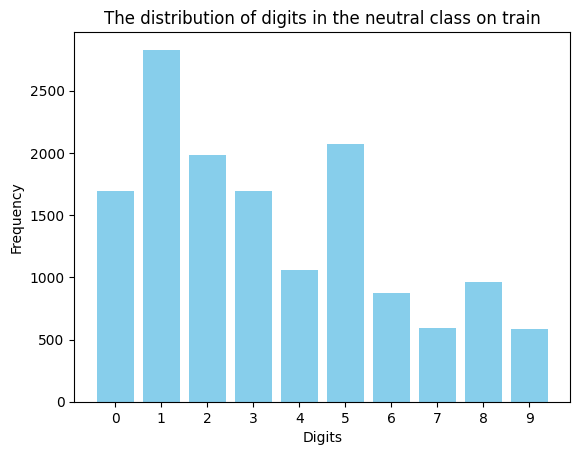

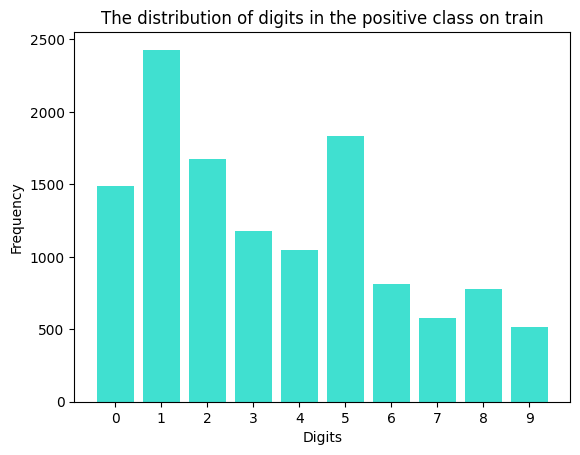

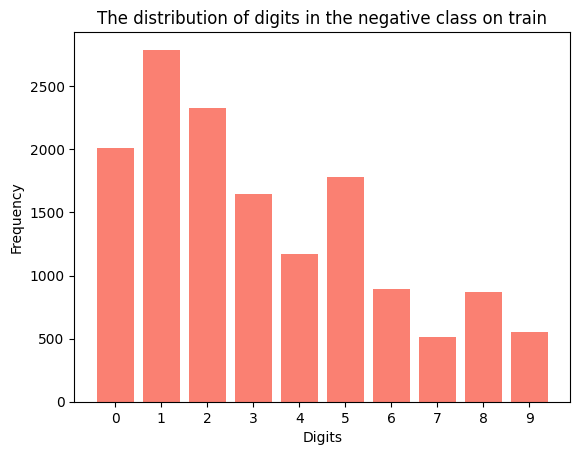

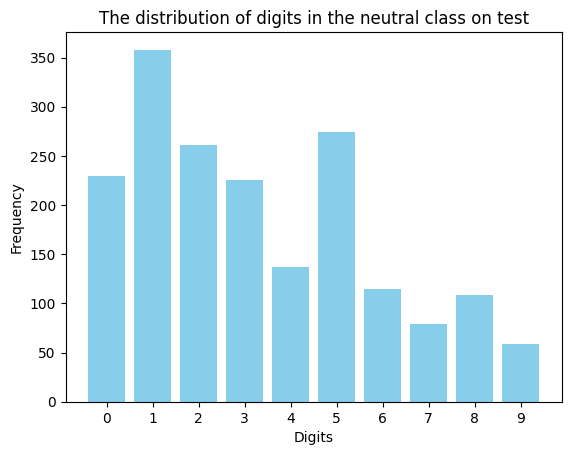

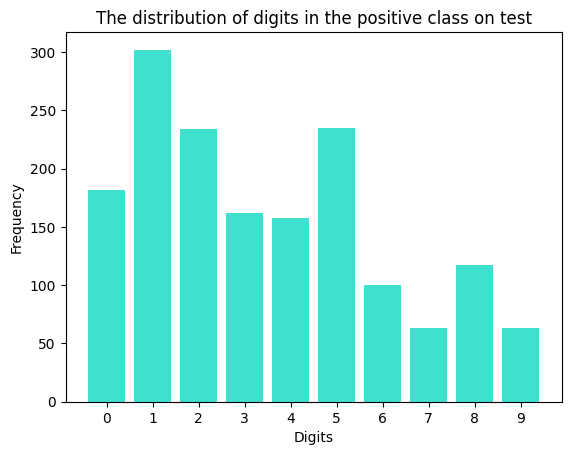

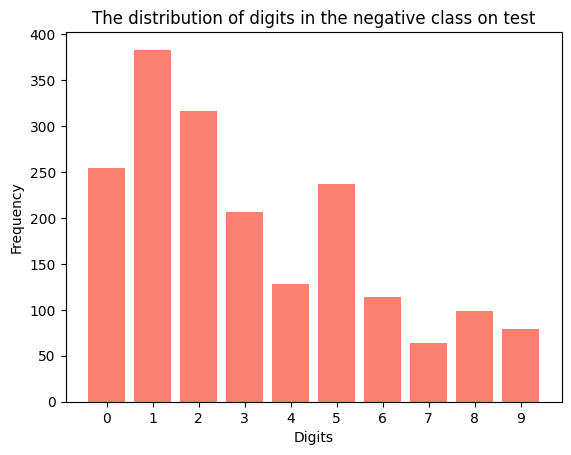

In [15]:
plot_cifre_per_clasa('neutral', 'skyblue', train_data_plot, 'train')
plot_cifre_per_clasa('positive', 'turquoise', train_data_plot, 'train')
plot_cifre_per_clasa('negative', 'salmon', train_data_plot, 'train')

plot_cifre_per_clasa('neutral', 'skyblue', test_data_plot, 'test')
plot_cifre_per_clasa('positive', 'turquoise', test_data_plot, 'test')
plot_cifre_per_clasa('negative', 'salmon', test_data_plot, 'test')

In [19]:
stop_words = set(stopwords.words('english'))

def plot_stopwords_per_clasa(label, color, data_csv, label_csv):
    data_per_clasa_words = data_csv[data_csv['label'] == label]['reviewText'].str.split()
   
    stops_count = defaultdict(int)
    for words in data_per_clasa_words:
        for word in words:
            if word.lower() in stop_words:
                stops_count[word] += 1
  
    stops_count = sorted(stops_count.items(), key= lambda x: x[1], reverse=True)
    stops_count = dict(stops_count[:15])
    
    plt.bar(stops_count.keys(), stops_count.values(), color=color)    
    plt.xlabel("Stopword")
    plt.ylabel("Frequency")
    plt.title(f"The distribution of the 15 most frequent stopwords in the {label} class on {label_csv}")
    plt.show() 


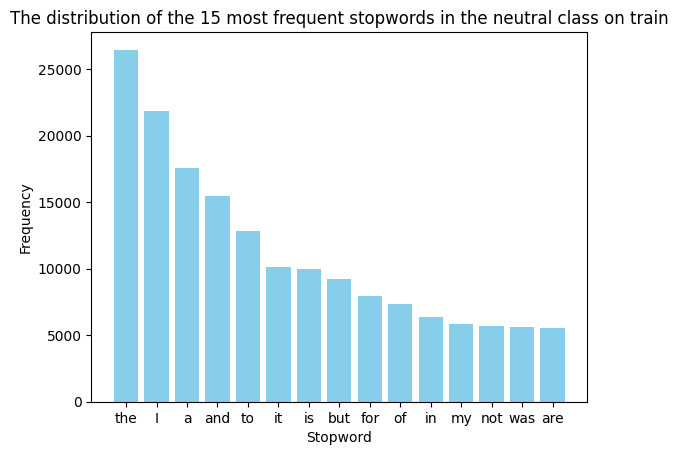

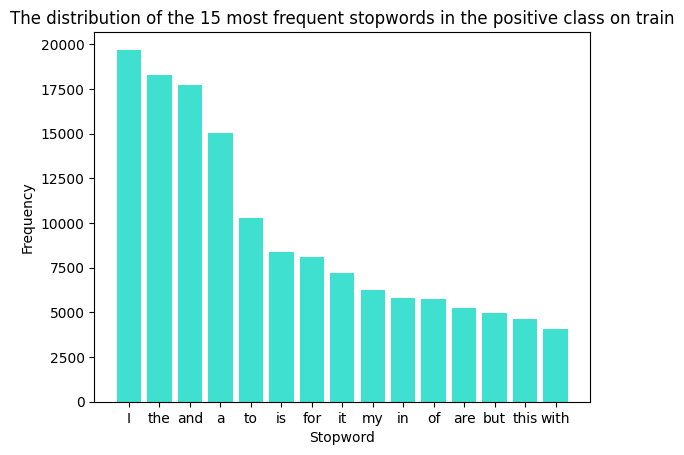

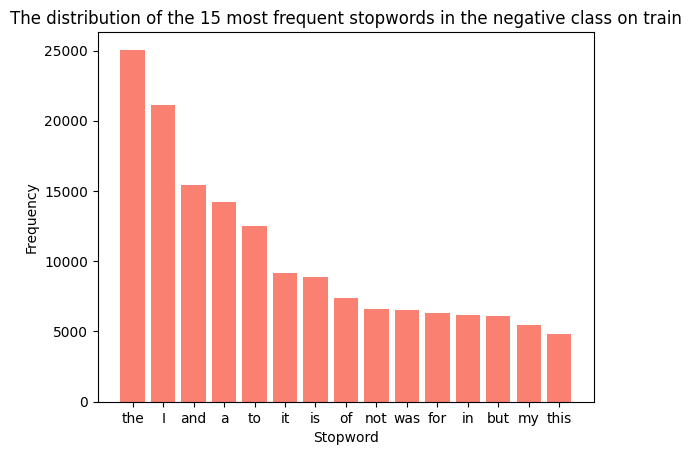

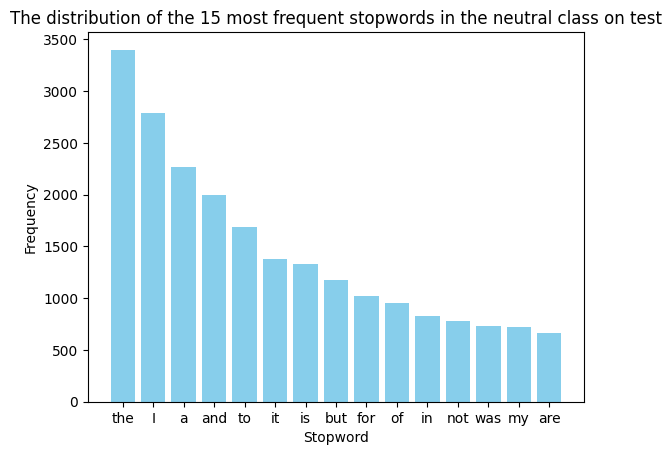

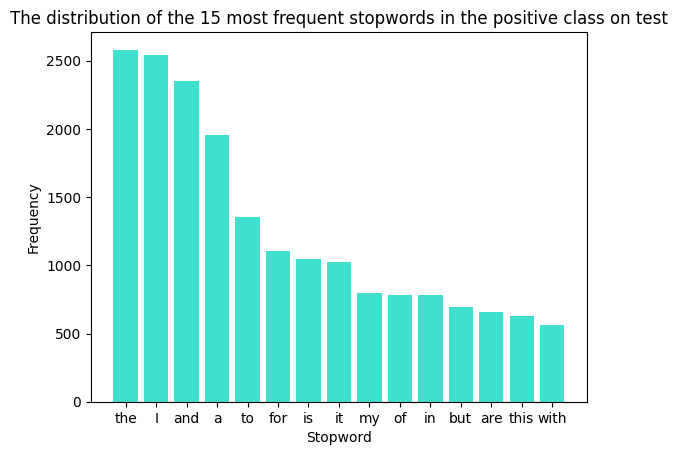

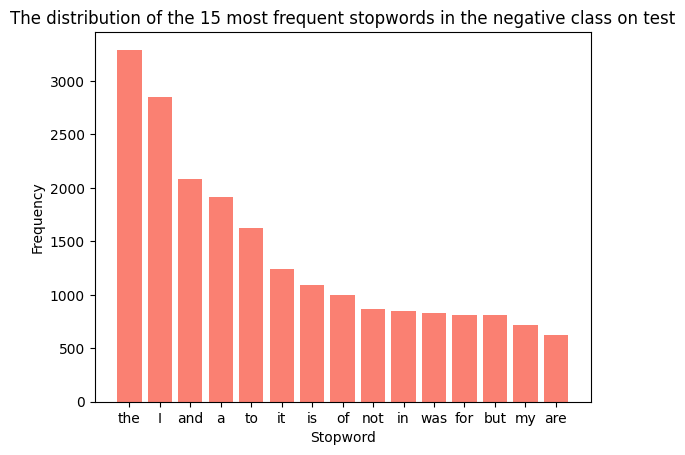

In [20]:
plot_stopwords_per_clasa('neutral', 'skyblue', train_data_plot, 'train')
plot_stopwords_per_clasa('positive', 'turquoise', train_data_plot, 'train')
plot_stopwords_per_clasa('negative', 'salmon', train_data_plot, 'train')

plot_stopwords_per_clasa('neutral', 'skyblue', test_data_plot, 'test')
plot_stopwords_per_clasa('positive', 'turquoise', test_data_plot, 'test')
plot_stopwords_per_clasa('negative', 'salmon', test_data_plot, 'test')

In [73]:
def class_distribution(df):
    label_counts = df['label'].value_counts()
    
    label_counts.plot(kind='pie')
    plt.xlabel('')
    plt.ylabel('')
    plt.title('Class Distribution on Train Data')
    
    plt.show()
    
    rating_counts = df['overall'].value_counts()
    
    rating_counts.plot(kind='bar')
    plt.xlabel('Review')
    plt.ylabel('Number of Reviews')
    plt.title('Rating Distribution on Train Data')
    plt.xticks(rotation=45, ha='right')
    
    
    plt.show()

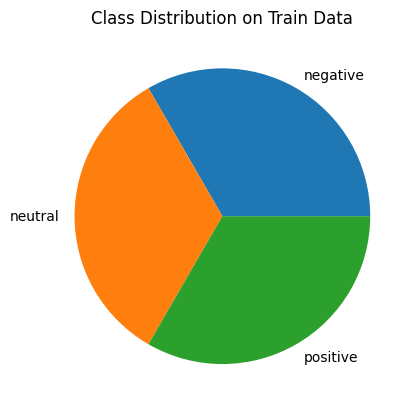

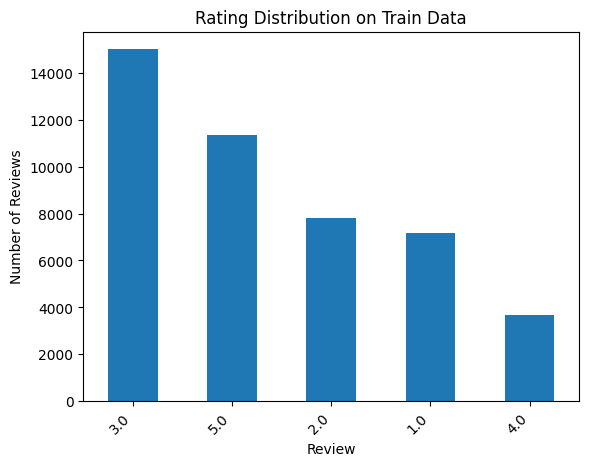

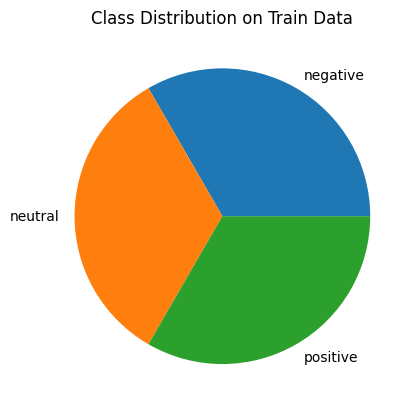

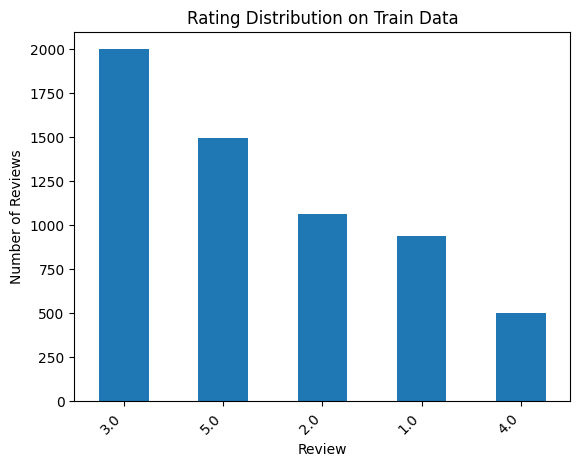

In [74]:
class_distribution(train_data_plot)
class_distribution(test_data_plot)

In [75]:
def count_punctuation(df):
    
    for i, label in enumerate(df['label'].unique()):
        df_label = df[df['label'] == label]
        
        punctuation_list = df_label['reviewText'].apply(lambda text: re.findall(r'[^\w\s]', text)).explode().tolist()
    
        top_punctuation = pd.Series(punctuation_list).value_counts().nlargest(10)
        top_punctuation.plot(kind='bar')
        plt.xlabel('Punctuation Mark')
        plt.ylabel('Count')
        plt.title(f'Punctuation Distribution for Label: {label}')
        plt.xticks(rotation=45, ha='right')
    
        plt.show()

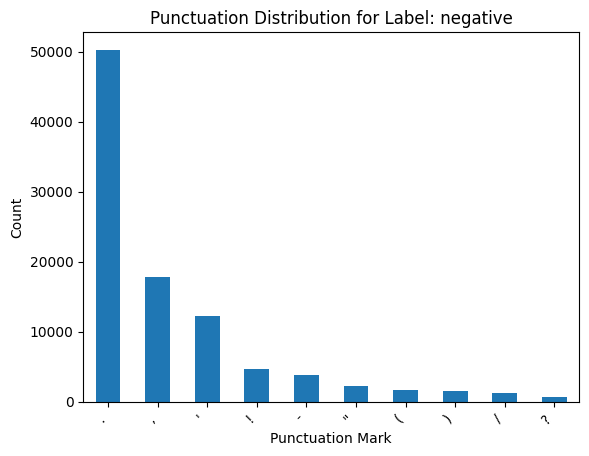

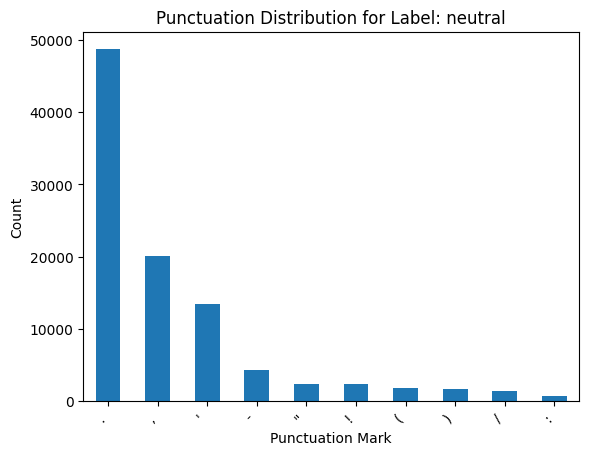

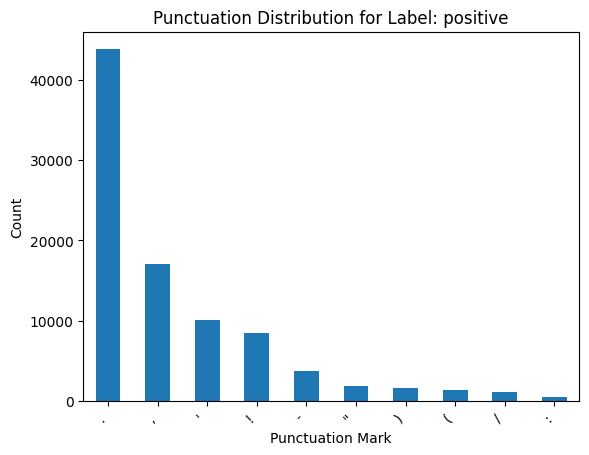

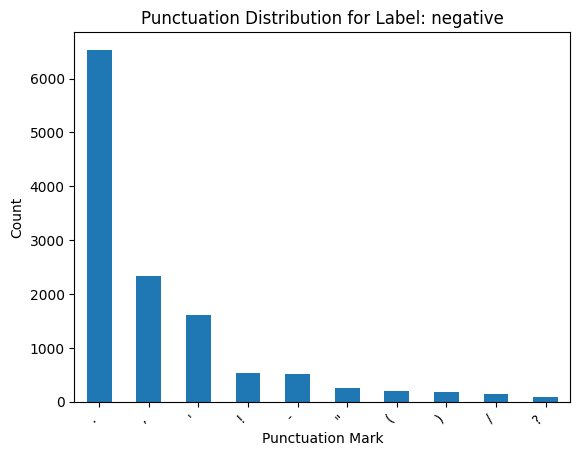

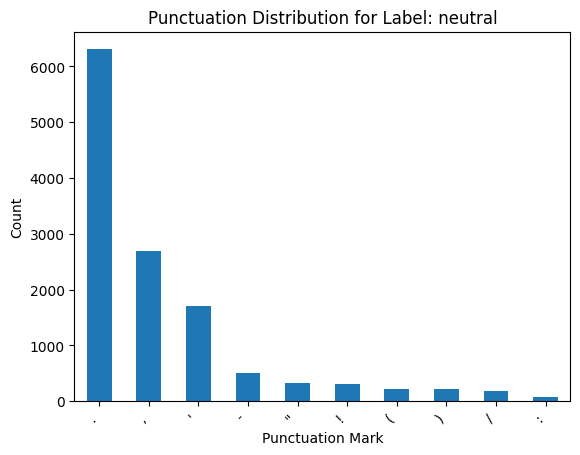

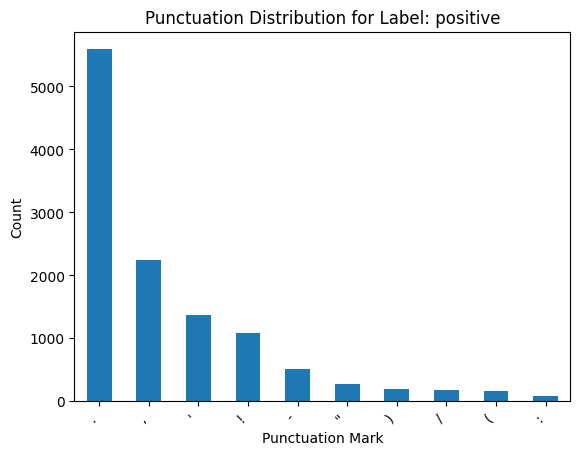

In [77]:
count_punctuation(train_data_plot)
count_punctuation(test_data_plot)

In [78]:
def plot_reviews_length(data_csv, label_csv):
    data_per_clasa = data_csv

    maximum_review = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
    maximum_review_per_class = {'positive':0, 'negative':0, 'neutral':0}
    
    for index, row in data_per_clasa.iterrows():
        review_text = row['reviewText']
        words = review_text.split()

        lenght_of_review = len(words)

        if maximum_review[row['overall']] < lenght_of_review:
            maximum_review[row['overall']] = lenght_of_review
        if maximum_review_per_class[row['label']] < lenght_of_review:
            maximum_review_per_class[row['label']] = lenght_of_review    
            
    ratings = list(maximum_review.keys())
    lengths = list(maximum_review.values())

    # Plotting
    plt.plot(ratings, lengths, color='hotpink', marker='*',label='')
    plt.xlabel('Rating')
    plt.ylabel('Maximum Review Length')
    plt.title(f'Maximum Review Length for each Rating ({label_csv})')
    plt.xticks(ratings) 
    plt.show()
    
    print(maximum_review_per_class)
    ratings = list(maximum_review_per_class.keys())
    lengths = list(maximum_review_per_class.values())

    # Plotting
    plt.bar(ratings, lengths, color=['turquoise','salmon','skyblue'])
    plt.xlabel('Label')
    plt.ylabel('Maximum Review Length')
    plt.title(f'Maximum Review Length for each Label ({label_csv})')
    plt.show()
    

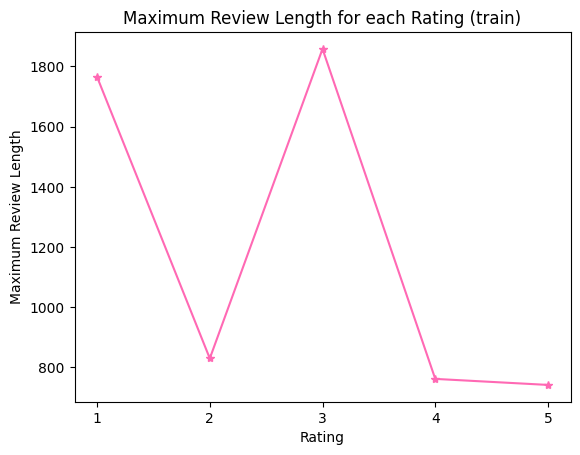

{'positive': 762, 'negative': 1765, 'neutral': 1858}


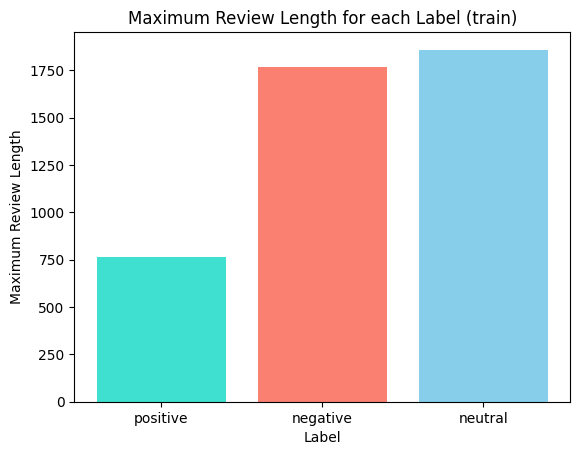

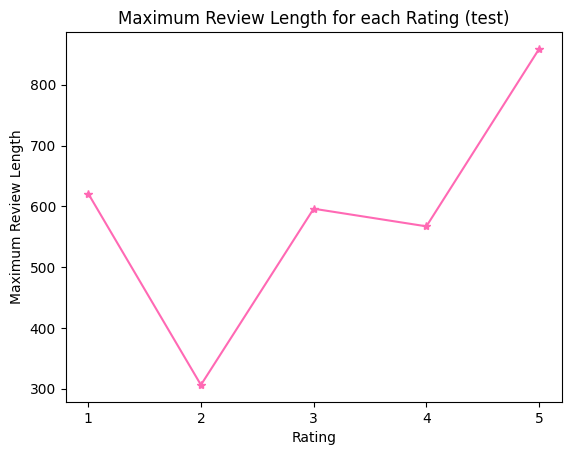

{'positive': 859, 'negative': 621, 'neutral': 596}


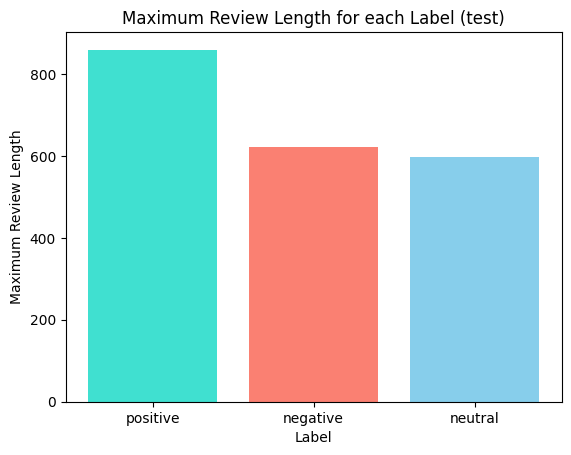

In [79]:
plot_reviews_length(train_data_plot, 'train')
plot_reviews_length(test_data_plot, 'test')